# `tinygp` in the wild

This notebook shows an example of fitting a `tinygp` model to some real data from [The EXPRES Stellar Signals Project (Zhao et al. 2022)](https://iopscience.iop.org/article/10.3847/1538-3881/ac5176/meta).
This is by no means meant to be a recommendation for how one might want to actually remove stellar variability, but it did seem fun to fit some real data here just to get a feel for it.

In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp    
    
try:
    import jaxopt
except ImportError:
    %pip install -q jaxopt

/opt/homebrew/Caskroom/miniforge/base/envs/tinygp/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


First, read and plot the data for one of the targets from The EXPRES Stellar Signals Project:

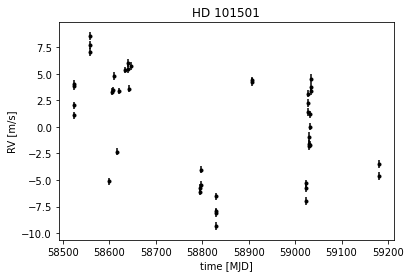

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.timeseries import LombScargle
import tinygp
import jax
import jax.numpy as jnp

import jaxopt

jax.config.update("jax_enable_x64", True)

hd = 101501
data = ascii.read("ajac5176t3_mrt.txt")
data = data[data["HD"] == hd]
t = np.ascontiguousarray(data["MJD"], dtype=float)
rv = np.ascontiguousarray(data["RVel1"], dtype=float)
rv_err = np.ascontiguousarray(data["e_RVel1"], dtype=float)

plt.errorbar(t, rv, yerr=rv_err, fmt=".k")
plt.xlabel("time [MJD]")
plt.ylabel("RV [m/s]")
plt.title(f"HD {hd}");

Let's compute the Lomb Scargle periodogram to look at the structure and to find a dominant frequency to use in our GP model below:

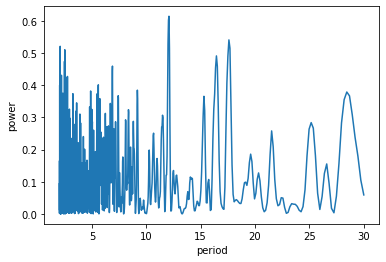

In [3]:
ls = LombScargle(t, rv, rv_err)
power = ls.autopower(minimum_frequency=1 / 30, maximum_frequency=1 / 2.0)
period = 1 / power[0][np.argmax(power[1])]

plt.plot(1/power[0], power[1])
plt.ylabel("power")
plt.xlabel("period");

Following the intro to `tinygp` tutorial, we build and fit a `tinygp` model:

In [4]:
from tinygp.kernels import quasisep

def build_gp(params, t, rv_err):
    omega = 2 * np.pi * jnp.exp(-params["log_period"])
    quality = 0.5 * omega * jnp.exp(params["log_ell2"])
    kernel = jnp.exp(params["log_amp1"]) * quasisep.Matern32(jnp.exp(params["log_ell1"]))
    kernel += jnp.exp(params["log_amp2"]) * quasisep.SHO(omega=omega, quality=quality)
    return tinygp.GaussianProcess(kernel, t, diag=jnp.square(rv_err) + jnp.exp(2 * params["log_jitter"]), mean=params["mean"])

@jax.jit
def loss(params):
    gp = build_gp(params, t, rv_err)
    return -gp.log_probability(rv)

params = {
    "mean": 0.0,
    "log_amp1": jnp.log(1.0),
    "log_ell1": jnp.log(10.0),
    "log_amp2": jnp.log(1.0),
    "log_ell2": jnp.log(100.0),
    "log_period": jnp.log(period),
    "log_jitter": jnp.log(1.0),
}
print(f"Initial negative log likelihood {loss(params)}")

Initial negative log likelihood 161.86766367271005


In [5]:
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 96.88328481674273


In [6]:
soln.params

{'log_amp1': DeviceArray(2.82152435, dtype=float64),
 'log_amp2': DeviceArray(1.18121554, dtype=float64),
 'log_ell1': DeviceArray(1.58058081, dtype=float64),
 'log_ell2': DeviceArray(31.19483348, dtype=float64),
 'log_jitter': DeviceArray(-0.11350507, dtype=float64),
 'log_period': DeviceArray(1.83011488, dtype=float64),
 'mean': DeviceArray(0.20833809, dtype=float64)}

Finally we plot the GP fit:

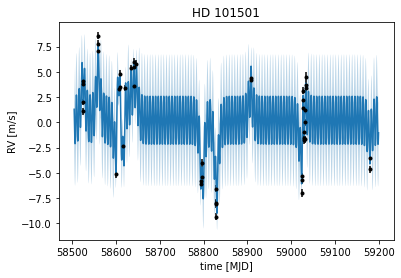

In [7]:
t_grid = jnp.linspace(t.min() - 20, t.max() + 20, 5000)

@jax.jit
def condition(params, t_pred):
    gp = build_gp(params, t, rv_err)
    cond = gp.condition(rv, t_pred)
    mu, var = cond.gp.loc, cond.gp.variance
    std = jnp.sqrt(var)
    return mu, std

mu, std = condition(soln.params, t_grid)
plt.errorbar(t, rv, yerr=rv_err, fmt=".k")
plt.plot(t_grid, mu)
plt.fill_between(t_grid, mu - std, mu + std, alpha=0.3)
plt.xlabel("time [MJD]")
plt.ylabel("RV [m/s]")
plt.title(f"HD {hd}");

That's not so illuminating, but we can zoom in on some well-sampled sections to get a sense for what's going on.

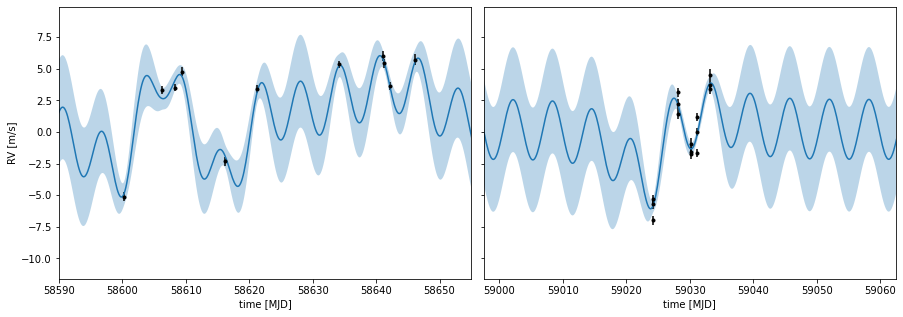

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for ax in axes:
    ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
    ax.plot(t_grid, mu)
    ax.fill_between(t_grid, mu - std, mu + std, alpha=0.3)
    ax.set_xlabel("time [MJD]")

axes[0].set_xlim(58590, 58655)
axes[1].set_xlim(58997.5, 59062.5)
axes[0].set_ylabel("RV [m/s]")
fig.subplots_adjust(wspace=0.03);

That looks pretty good.
We're definitely overfitting, and this wouldn't be a good way to pre-process the data to remove stellar variability, but we could combine this with a Keplerian mean model to constrain the parameters of a planetary orbit.